In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import itertools
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import balanced_accuracy_score,average_precision_score, precision_recall_curve, roc_curve, auc, recall_score, precision_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm.sklearn import LGBMClassifier
import lightgbm
import eli5
from eli5.sklearn import PermutationImportance
from helpers import convert_to_lime_format
from lime.lime_tabular import LimeTabularExplainer

Using TensorFlow backend.


### Dataset

Los datos se pueden encontrar [Aquí](https://archive.ics.uci.edu/ml/datasets/bank+marketing). 

El dataset contiene información de campañas de marketing de un banco portugués. 

- variable objetivo: si un cliente contratará un depósito a plazo (columna `y`). 

- Se construirá un algoritmo con complejidad para explicar los resultados. 
    La parte del modelado no tendrá optimización de hiperparámetros y tendrá un preprocesamiento simple , para que podamos enfocarnos en interpretar nuestros modelos y ver qué recomendación podemos hacer a los expertos del dominio (en este caso, la persona a cargo de la campaña de marketing).

- Las variables explicativas son:

    1. `age` (numeric)
    2. `job` : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
    3. `marital` : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
    4. `education` (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
    5. `default`: has credit in default? (categorical: 'no','yes','unknown')
    6. `housing`: has housing loan? (categorical: 'no','yes','unknown')
    7. `loan`: has personal loan? (categorical: 'no','yes','unknown')
    8. `contact`: contact communication type (categorical: 'cellular','telephone') 
    9. `month`: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
    10. `day_of_week`: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
    11. `campaign`: number of contacts performed during this campaign and for this client (numeric, includes last contact)
    12. `pdays`: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
    13. `previous`: number of contacts performed before this campaign and for this client (numeric)
    14. `poutcome`: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
    
    
*Además añado una variable aleatoria para poder interpretar mejor la importancia de las variables

In [2]:
df = pd.read_csv("data/bank.csv")
print(df.shape)
df.head()

(41188, 15)


age        job  marital    education  default housing loan    contact  \
0   56  housemaid  married     basic.4y       no      no   no  telephone   
1   57   services  married  high.school  unknown      no   no  telephone   
2   37   services  married  high.school       no     yes   no  telephone   
3   40     admin.  married     basic.6y       no      no   no  telephone   
4   56   services  married  high.school       no      no  yes  telephone   

  month day_of_week  campaign  pdays  previous     poutcome   y  
0   may         mon         1    999         0  nonexistent  no  
1   may         mon         1    999         0  nonexistent  no  
2   may         mon         1    999         0  nonexistent  no  
3   may         mon         1    999         0  nonexistent  no  
4   may         mon         1    999         0  nonexistent  no

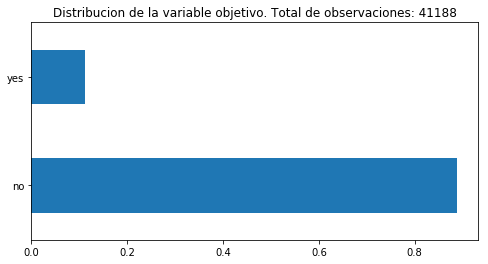

In [3]:
_=df.loc[:,'y']\
  .value_counts(normalize=True)\
  .plot(kind='barh', title='Distribucion de la variable objetivo. Total de observaciones: '+str(df.shape[0]),
        figsize=(8,4))

El dataser está desbalanceado

In [4]:
y = df["y"].map({"no": 0, "yes": 1})
X = df.drop("y", axis=1)
X['random'] = np.random.randint(100, size=X.shape[0])
X.dtypes

age             int64
job            object
marital        object
education      object
default        object
housing        object
loan           object
contact        object
month          object
day_of_week    object
campaign        int64
pdays           int64
previous        int64
poutcome       object
random          int32
dtype: object

Cuales de las características pueden ser las más relevantes para predecir las subscripciones? Es posible que inicialmente se tenga una idea intuitiva. Para interpretar si esta idea es similar a como actúa el modelo, es necesario interpretar los resultados

En primer lugar, se crea una lista de las variables numericas y las variables categoricas

In [5]:
num_features = ["age", "campaign", "pdays", "previous", "random"]
cat_features = ["job", "marital", "education","default", "housing", "loan",
                "contact", "month", "day_of_week", "poutcome"]

Separamos en train, test el dataset

In [6]:
X_train_ini, X_test_ini, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.15, random_state=42)


Definimos un nuevo objeto `ColumnTransformer` que mantiene las características numéricas como están y convierte a dummy (onehot) las columnas categoricas

In [7]:
preprocessor = ColumnTransformer([("numerical", "passthrough", num_features), 
                                  ("categorical", OneHotEncoder(sparse=False, handle_unknown="ignore"),
                                   cat_features)])
preprocessor.fit(X_train_ini)

ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
                  transformer_weights=None,
                  transformers=[('numerical', 'passthrough',
                                 ['age', 'campaign', 'pdays', 'previous',
                                  'random']),
                                ('categorical',
                                 OneHotEncoder(categorical_features=None,
                                               categories=None, drop=None,
                                               dtype=<class 'numpy.float64'>,
                                               handle_unknown='ignore',
                                               n_values=None, sparse=False),
                                 ['job', 'marital', 'education', 'default',
                                  'housing', 'loan', 'contact', 'month',
                                  'day_of_week', 'poutcome'])],
                  verbose=False)

In [8]:
cat_values = preprocessor.named_transformers_["categorical"].categories_
# Lista de las categorias de cada una de las variables categoricas
ohe_categories = preprocessor.named_transformers_["categorical"].categories_
# Se crean nuevos valores de las categorias
new_ohe_features = [f"{col}__{val}" 
                    for col, vals in zip(cat_features, ohe_categories) for val in vals]
# Se crea una lista con todos los nombres de las categorias
all_features = num_features + new_ohe_features

Se crea el nuevo dataset con la transformacion de las columnas y los nuevos nombres

In [9]:
X_train = pd.DataFrame(preprocessor.transform(X_train_ini), columns=all_features, index=X_train_ini.index)
X_test = pd.DataFrame(preprocessor.transform(X_test_ini), columns=all_features, index=X_test_ini.index)
print(X_train.shape)
print(X_test.shape)

(35009, 58)
(6179, 58)


In [10]:
X_train.head()

age  campaign  pdays  previous  random  job__admin.  job__blue-collar  \
49     45.0       2.0  999.0       0.0     1.0          0.0               1.0   
17719  48.0       4.0  999.0       0.0    83.0          0.0               0.0   
25132  38.0       1.0  999.0       1.0     7.0          0.0               0.0   
33733  51.0       1.0  999.0       0.0    32.0          1.0               0.0   
28109  31.0       1.0  999.0       1.0    67.0          0.0               0.0   

       job__entrepreneur  job__housemaid  job__management  ...  month__oct  \
49                   0.0             0.0              0.0  ...         0.0   
17719                0.0             0.0              0.0  ...         0.0   
25132                0.0             0.0              0.0  ...         0.0   
33733                0.0             0.0              0.0  ...         0.0   
28109                0.0             0.0              0.0  ...         0.0   

       month__sep  day_of_week__fri  day_of_week__mon  day_of_week__thu  \
49            0.0               0.0               1.0               0.0   
17719         0.0               0.0               0.0               0.0   
25132         0.0               0.0               0.0               0.0   
33733         0.0               0.0               0.0               0.0   
28109         0.0               1.0               0.0               0.0   

       day_of_week__tue  day_of_week__wed  poutcome__failure  \
49                  0.0               0.0                0.0   
17719               1.0               0.0                0.0   
25132               1.0               0.0                1.0   
33733               0.0               1.0                0.0   
28109               0.0               0.0                1.0   

       poutcome__nonexistent  poutcome__success  
49                       1.0                0.0  
17719                    1.0                0.0  
25132                    0.0                0.0  
33733                    1.0                0.0  
28109                    0.0                0.0  

[5 rows x 58 columns]

## Ajuste LightGBM

In [11]:
# LightGBM -- Boosting model
from lightgbm import LGBMClassifier
# train_data = lightgbm.Dataset(X_train, label=y_train)
# test_data = lightgbm.Dataset(X_test, label=y_test)

In [12]:
%%time
evals_result = {}

lgb = LGBMClassifier(n_estimators=180,
                    application= 'binary',
                    objective= 'binary',
                    metric= 'binary_logloss',
                    boosting='gbdt',
                    num_leaves= 50,
                    min_data_in_leaf= 200,
                    feature_fraction= 0.8,
                    bagging_fraction= 0.8,
                    learning_rate= 0.01,
                    max_depth= 12,
                    verbose= 1)

model = lgb.fit(X_train, y_train)

# predicción de TRAIN
pd_train_predicted = pd.DataFrame(model.predict_proba(X_train), 
                                index=X_train.index, columns = ['y_predicted_0', 'y_predicted']).drop(['y_predicted_0'],axis=1)
pd_train_predicted_final = pd.concat([X_train, pd_train_predicted, y_train],axis=1)

# predicción de TEST
pd_test_predicted = pd.DataFrame(model.predict_proba(X_test), 
                                 index=X_test.index, columns = ['y_predicted_0', 'y_predicted']).drop(['y_predicted_0'],axis=1)
pd_test_predicted_final = pd.concat([X_test, pd_test_predicted, y_test],axis=1)

Wall time: 1.26 s


### Curvas PRC

In [13]:

def plot_prc(y, y_predicted, ax, name_title, titlesize=30, other_size=12):
    
    matplotlib.rc('font', size=other_size)
    matplotlib.rc('axes', titlesize=titlesize)
    matplotlib.rc('axes', labelsize=other_size)
    matplotlib.rc('ytick', labelsize=other_size)
    matplotlib.rc('legend', fontsize=other_size)
    matplotlib.rc('figure', titlesize=other_size)
    matplotlib.rc('xtick', labelsize=other_size)
    average_precision = average_precision_score(y,y_predicted)
    
    lr_precision, lr_recall, _=precision_recall_curve(y, y_predicted)
    
    plt.ylim([0,1])
    no_skill= len(y[y==1])/len(y)
    ax.plot([0,1],[no_skill, no_skill], linestyle='--')
    ax.plot(lr_recall, lr_precision, marker='.')
    ax.set_title('PRC_'+str(name_title)+'_'+str(round(average_precision,2)))
    ax.set_ylim([0,1.01])
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')

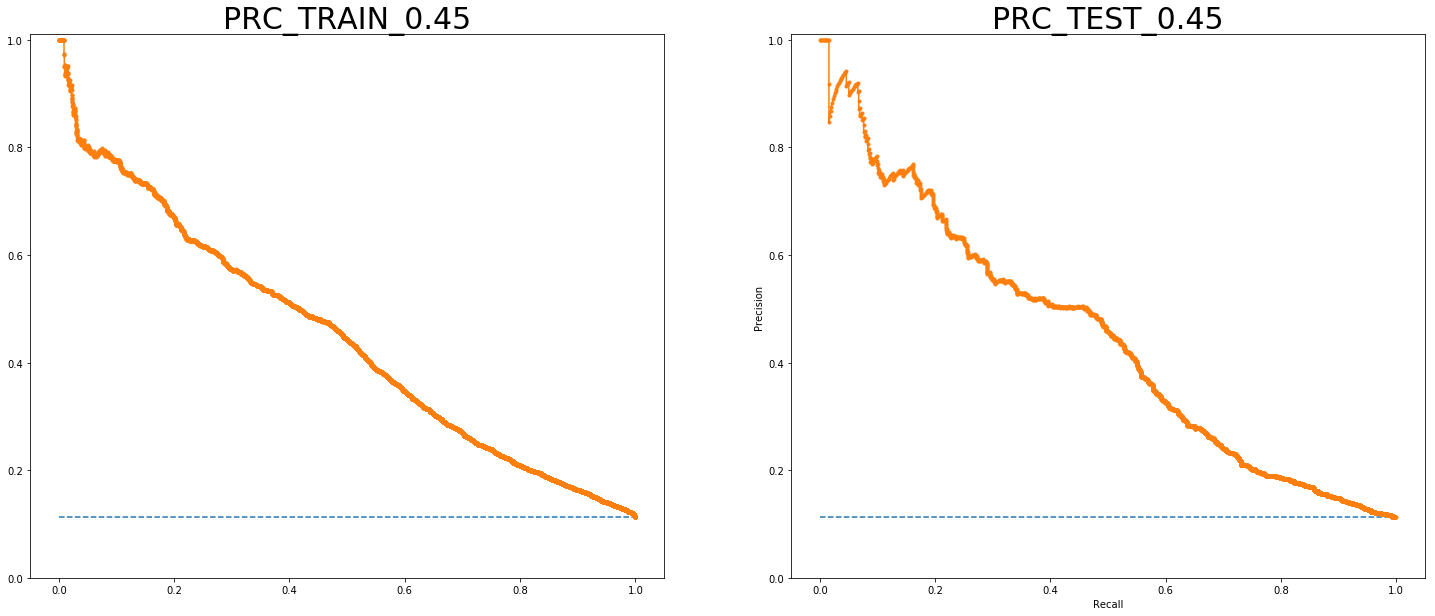

In [14]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(25,10))
plot_prc(pd_train_predicted_final.y, pd_train_predicted_final.y_predicted,ax1,'TRAIN')
plot_prc(pd_test_predicted_final.y, pd_test_predicted_final.y_predicted,ax2,'TEST')

In [15]:
def plot_roc_gini(y_true=None,y_pred=None, size_figure=[9,9], tittle = 'Curva Roc'):

    if ((y_true is None) or (y_pred is None)):
        print(u'\nFaltan parámetros por pasar a la función')
        return 1

    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=size_figure)
    plt.plot(fpr, tpr, color='darkorange',
             lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.00])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(tittle)
    plt.legend(loc="lower right")
    plt.show()

    gini = (2.0 * roc_auc) - 1.0

    print('\n*************************************************************')
    print(u'\nEl coeficiente de GINI es: %0.2f' % gini)
    print(u'\nEl área por debajo de la curva ROC es: %0.2f' %roc_auc)
    print('\n*************************************************************')

    return 0

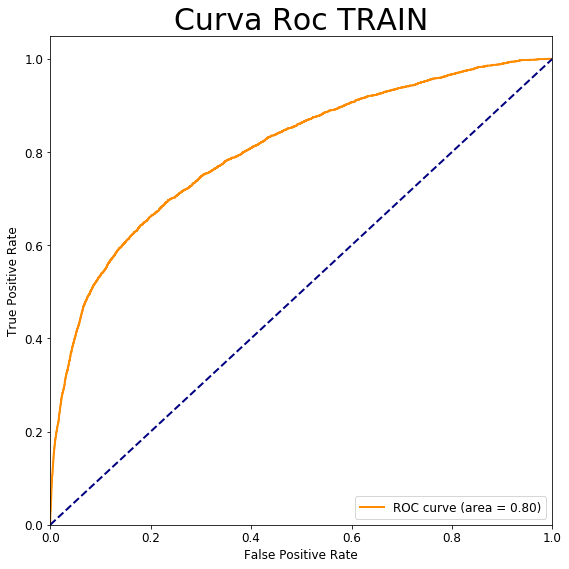


*************************************************************

El coeficiente de GINI es: 0.61

El área por debajo de la curva ROC es: 0.80

*************************************************************


0

In [16]:
plot_roc_gini(pd_train_predicted_final.y, pd_train_predicted_final.y_predicted,
              size_figure=[9,9], tittle = 'Curva Roc TRAIN')

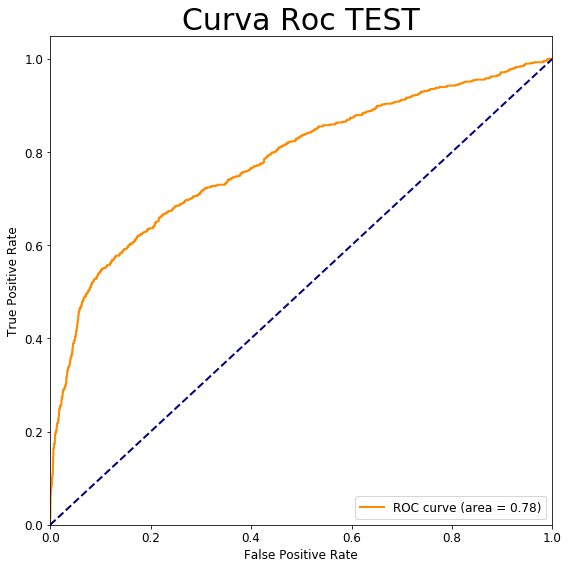


*************************************************************

El coeficiente de GINI es: 0.56

El área por debajo de la curva ROC es: 0.78

*************************************************************


0

In [17]:
plot_roc_gini(pd_test_predicted_final.y, pd_test_predicted_final.y_predicted,
              size_figure=[9,9], tittle = 'Curva Roc TEST')

### Elección del mejor corte

In [18]:
%%time
prob_predictions = pd_train_predicted_final.y_predicted.values
recall_precision = []

for threshold in np.arange(0.01, 0.99, 0.01):
    
    given_threshold = [1 if value>threshold else 0 for value in prob_predictions]
    recall_precision.append([threshold, recall_score(pd_train_predicted_final.y, given_threshold),
                            precision_score(pd_train_predicted_final.y, given_threshold)])

C:\Users\Ana\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Wall time: 3.73 s


In [19]:
def plot_recall_precission(recall_precision):

    plt.figure(figsize=(15, 5))
    ax = sns.pointplot(x = [element[0] for element in recall_precision], y=[element[1] for element in recall_precision],
                     color="r", label='recall', scale=1)
    ax = sns.pointplot(x = [element[0] for element in recall_precision], y=[element[2] for element in recall_precision],
                     color="b", label='precission')
    ax.set_title('recall-precision versus threshold')
    ax.set_xlabel('threshold')
    ax.set_ylabel('probability')

    labels = ax.get_xticklabels()
    for i,l in enumerate(labels):
        if(i%5 == 0) or (i%5 ==1) or (i%5 == 2) or (i%5 == 3):
            labels[i] = '' # skip even labels
            ax.set_xticklabels(labels, rotation=45, fontdict={'size': 10})
    plt.show()

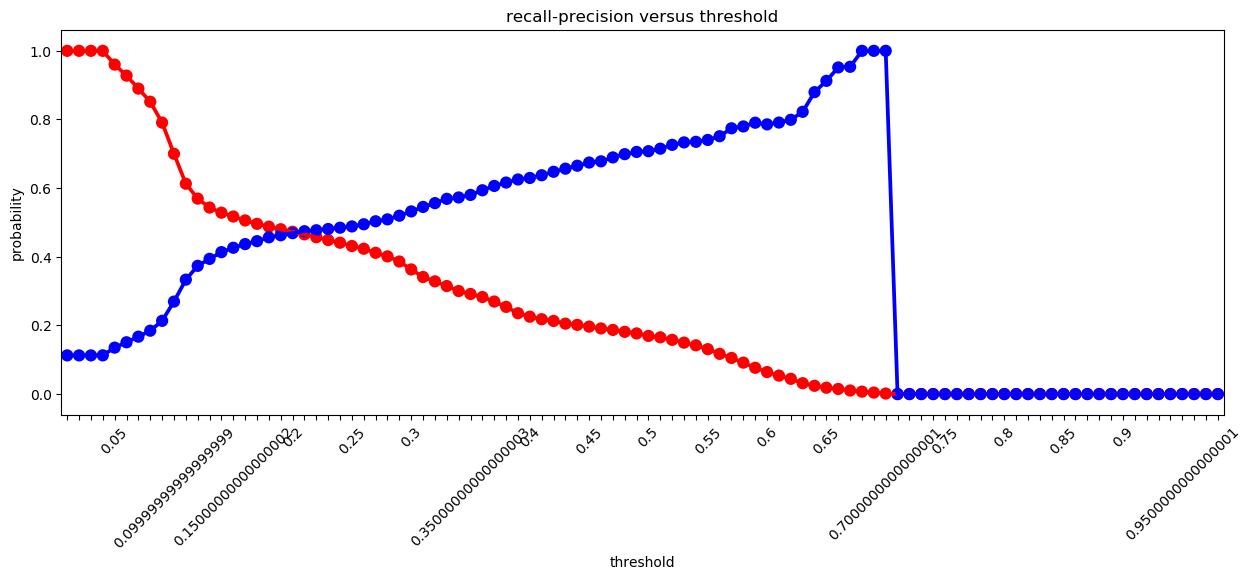

In [20]:
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plot_recall_precission(recall_precision)

### Matrices de confusión

In [21]:
def binary_target(x):
    if x<=0.09:
        y=0
    else:
        y=1
    return y

pd_train_predicted_final = pd_train_predicted_final\
                            .assign(binary_y_predicted = pd_train_predicted_final['y_predicted'].apply(binary_target))

pd_test_predicted_final = pd_test_predicted_final\
                            .assign(binary_y_predicted = pd_test_predicted_final['y_predicted'].apply(binary_target))

In [22]:
pd_train_predicted_final.head()

age  campaign  pdays  previous  random  job__admin.  job__blue-collar  \
49     45.0       2.0  999.0       0.0     1.0          0.0               1.0   
17719  48.0       4.0  999.0       0.0    83.0          0.0               0.0   
25132  38.0       1.0  999.0       1.0     7.0          0.0               0.0   
33733  51.0       1.0  999.0       0.0    32.0          1.0               0.0   
28109  31.0       1.0  999.0       1.0    67.0          0.0               0.0   

       job__entrepreneur  job__housemaid  job__management  ...  \
49                   0.0             0.0              0.0  ...   
17719                0.0             0.0              0.0  ...   
25132                0.0             0.0              0.0  ...   
33733                0.0             0.0              0.0  ...   
28109                0.0             0.0              0.0  ...   

       day_of_week__mon  day_of_week__thu  day_of_week__tue  day_of_week__wed  \
49                  1.0               0.0               0.0               0.0   
17719               0.0               0.0               1.0               0.0   
25132               0.0               0.0               1.0               0.0   
33733               0.0               0.0               0.0               1.0   
28109               0.0               0.0               0.0               0.0   

       poutcome__failure  poutcome__nonexistent  poutcome__success  \
49                   0.0                    1.0                0.0   
17719                0.0                    1.0                0.0   
25132                1.0                    0.0                0.0   
33733                0.0                    1.0                0.0   
28109                1.0                    0.0                0.0   

       y_predicted  y  binary_y_predicted  
49        0.047693  0                   0  
17719     0.067748  0                   0  
25132     0.088789  0                   0  
33733     0.112803  0                   1  
28109     0.101644  0                   1  

[5 rows x 61 columns]

In [23]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
   
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.show()

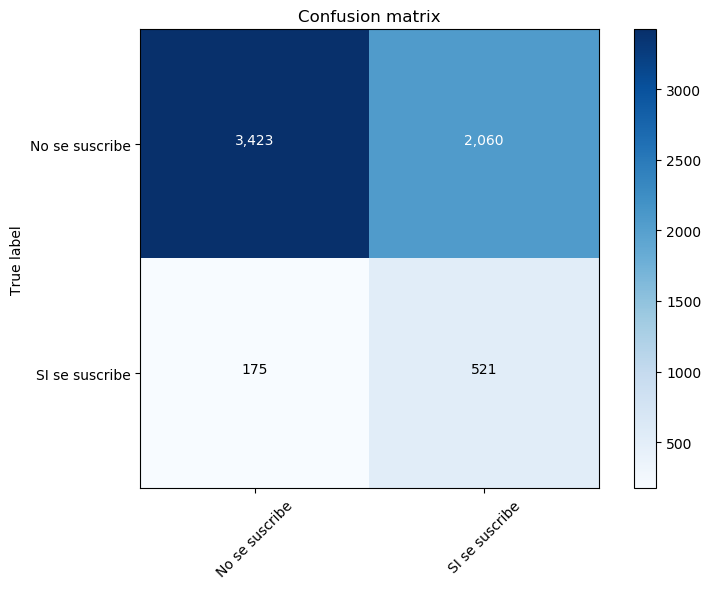

In [24]:
cm = confusion_matrix(pd_test_predicted_final.y.values,
                      pd_test_predicted_final.binary_y_predicted.values)
plot_confusion_matrix(cm,target_names=['No se suscribe', 'SI se suscribe'],
                      title='Confusion matrix',
                      cmap=None, normalize=False)

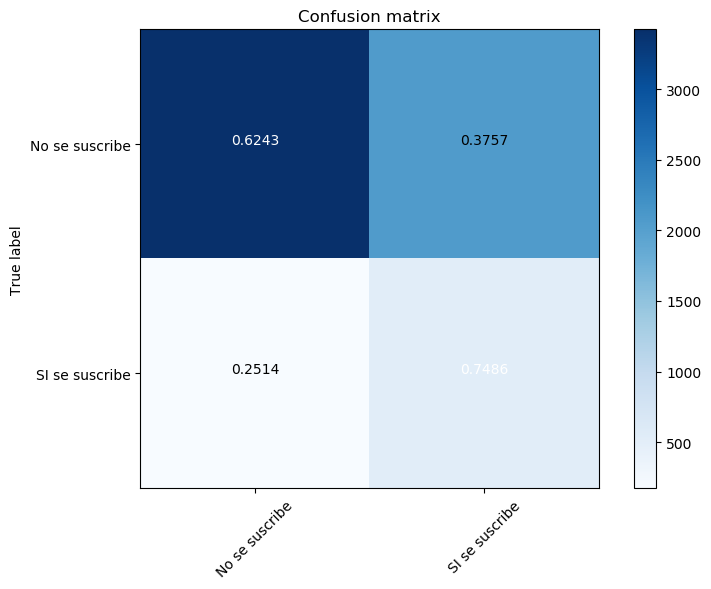

In [25]:
cm = confusion_matrix(pd_test_predicted_final.y.values,
                      pd_test_predicted_final.binary_y_predicted.values)
plot_confusion_matrix(cm,target_names=['No se suscribe', 'SI se suscribe'],
                      title='Confusion matrix',
                      cmap=None, normalize=True)

In [26]:
#lightgbm.plot_importance(model, ax=None, importance_type='gain', max_num_features=20)

## Permutation Importance

`eli5` implementa otra técnica llamada `PermutationImportance`. 
La idea es la siguiente: la importancia de la característica puede medirse observando cuánto disminuye el score (precisión, F1, R^2, etc. - cualquier puntuación que nos interese) cuando una característica no está disponible.

Para evitar el reentrenamiento del modelo se "transforma aleatoriamente" una característica de la parte de test del conjunto de datos, y se recalcula el score sin usar la característica. La característica se reemplaza por una variable aleatoria, es decir, la columna de características sigue ahí, pero ya no contiene información útil. Este método funciona si la variable aleatoria se extrae de la misma distribución que los valores de las características originales (ya que de lo contrario el modelo puede fallar). El método es más adecuado para calcular la importancia de las características cuando un número de columnas (características) no es grande.

In [27]:
%%time
perm = PermutationImportance(model, scoring="balanced_accuracy")
perm.fit(X_test, y_test)
eli5.show_weights(perm, feature_names=all_features)

Wall time: 25.1 s


El inconveniente de esta librería:no obtener en qué dirección esto afectará el resultado (lo que sería útil para hacer recomendaciones más concretas). Pero al menos es posible usar este método para cualquier modelo y comparar los resultados.


## Método LIME




In [28]:
categorical_names = {}
for col, val in zip(cat_features, cat_values):
    categorical_names[df.columns.get_loc(col)] = list(val)

In [29]:
def convert_to_lime_format(X, categorical_names, col_names=None, invert=False):
    """Converts data with categorical values as string into the right format 
    for LIME, with categorical values as integers labels.
    """
    if not isinstance(X, pd.DataFrame):
        X_lime = pd.DataFrame(X, columns=col_names)
    else:
        X_lime = X.copy()

    for k, v in categorical_names.items():
        if not invert:
            label_map = {str_label: int_label for int_label, str_label in enumerate(v)}
        else:
            label_map = {int_label: str_label for int_label, str_label in enumerate(v)}

        X_lime.iloc[:, k] = X_lime.iloc[:, k].map(label_map)

    return X_lime

In [30]:
from functools import partial

def custom_predict_proba(X, model):
    """Takes X in LIME format, converts back to raw,
    then processes it and calls predict proba"""
    X_original = convert_to_lime_format(X, categorical_names, 
                                        col_names=X_train_ini.columns, invert=True)
    X_processed = preprocessor.transform(X_original)

    return model.predict_proba(X_processed)

lgb_predict_proba = partial(custom_predict_proba, model=model)

In [31]:
%%time
i = 888
X_observation = X_test_ini.iloc[[i], :]
observation = convert_to_lime_format(X_test_ini.iloc[[i], :],
                                      categorical_names, invert=False).values[0]
explainer =LimeTabularExplainer(convert_to_lime_format(X_train_ini, categorical_names).values,
                                 mode="classification",
                                 feature_names=X_train_ini.columns,
                                 categorical_names=categorical_names,
                                 categorical_features=categorical_names.keys(),
                                 random_state=42)

explanation = explainer.explain_instance(observation,
                                         lgb_predict_proba, num_features=10, num_samples=1000)
explanation.show_in_notebook(show_table=True, show_all=False)

Wall time: 366 ms


In [32]:
%%time
i = 400
X_observation = X_test_ini.iloc[[i], :]
observation = convert_to_lime_format(X_test_ini.iloc[[i], :],
                                      categorical_names, invert=False).values[0]
explainer =LimeTabularExplainer(convert_to_lime_format(X_train_ini, categorical_names).values,
                                 mode="classification",
                                 feature_names=X_train_ini.columns,
                                 categorical_names=categorical_names,
                                 categorical_features=categorical_names.keys(),
                                 random_state=42)

explanation = explainer.explain_instance(observation,
                                         lgb_predict_proba, num_features=10, num_samples=1000)
explanation.show_in_notebook(show_table=True, show_all=False)

Wall time: 442 ms


## Método SHAP

In [33]:
import shap
# Need to load JS vis in the notebook
shap.initjs() 

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


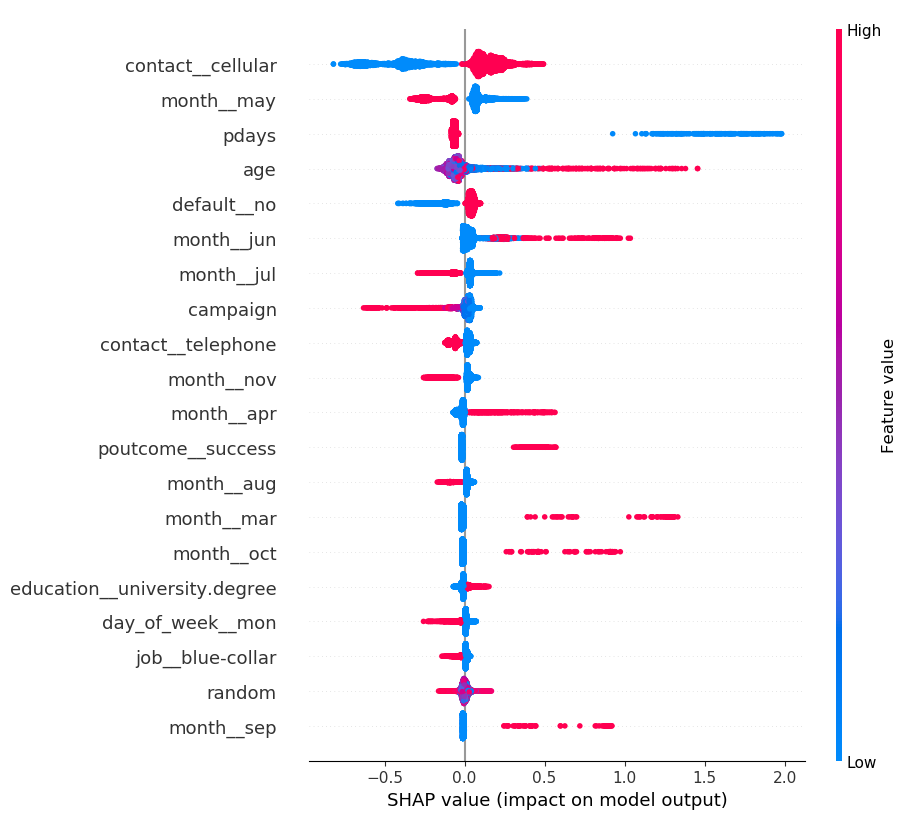

Wall time: 7.77 s


In [34]:
%%time
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values[1], X_test)

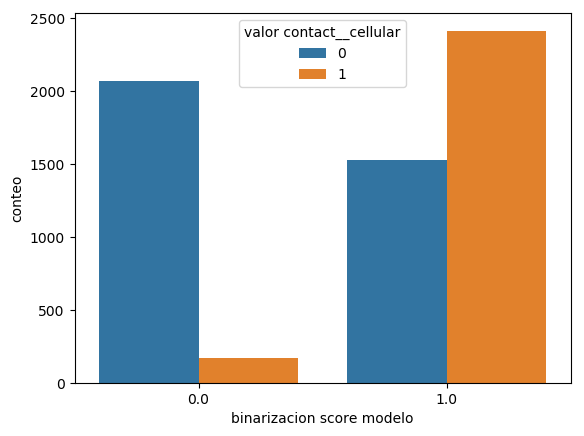

In [35]:
pd_contact_cellular = pd_test_predicted_final[['contact__cellular', 'binary_y_predicted', 'y']]\
        .groupby(['contact__cellular', 'binary_y_predicted'])['y']\
        .count()
pd_contact_cellular = pd_contact_cellular.reset_index()
pd_contact_cellular.columns = ['binarizacion score modelo', 'valor contact__cellular', 'conteo']
ax = sns.barplot(x='binarizacion score modelo', y='conteo', hue='valor contact__cellular', data=pd_contact_cellular)

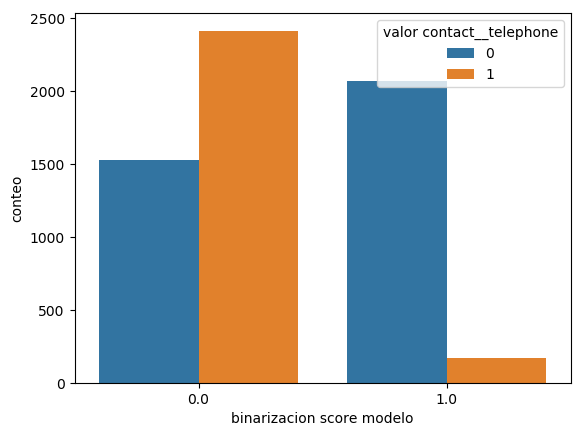

In [36]:
pd_contact_cellular = pd_test_predicted_final[['contact__telephone', 'binary_y_predicted', 'y']]\
        .groupby(['contact__telephone', 'binary_y_predicted'])['y']\
        .count()
pd_contact_cellular = pd_contact_cellular.reset_index()
pd_contact_cellular.columns = ['binarizacion score modelo', 'valor contact__telephone', 'conteo']
ax = sns.barplot(x='binarizacion score modelo', y='conteo', hue='valor contact__telephone', data=pd_contact_cellular)

In [37]:
# %%time

# ### Si ponemos que explique las probabilidades, va un poquito más despacio

# explainer = shap.TreeExplainer(model, data=X_test, model_output="probability",
#                                feature_perturbation="interventional")
# data=shap.sample(X_test, 1000)
# shap_values = explainer.shap_values(data)
# shap.summary_plot(shap_values, data)

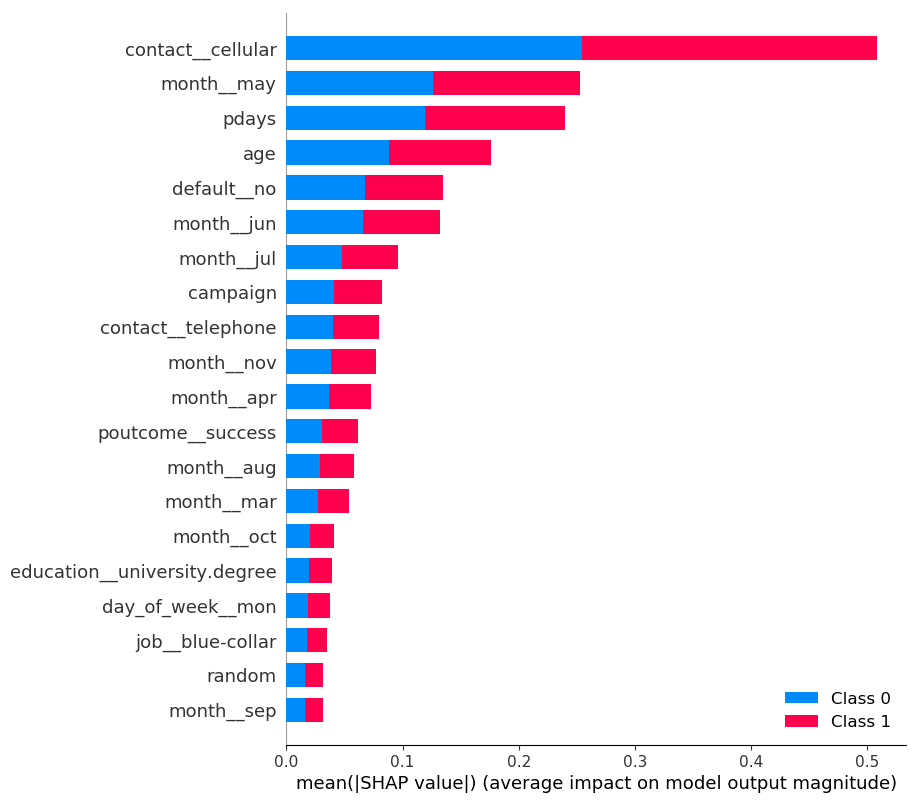

In [38]:
shap.summary_plot(shap_values, X_test)

In [39]:
shap.force_plot(explainer.expected_value[1], shap_values[1][888,:], X_test.iloc[888,:], link='logit')

In [40]:
shap.force_plot(explainer.expected_value[1], shap_values[1][400,:], X_test.iloc[400,:], link='logit')

Además, también se pueden realizar gráficos de dependencia parcial

### SHAP + LIGHTGBM

In [41]:
%%time
pd_shap = pd.DataFrame(model.predict_proba(X_test, pred_contrib=True), 
                       columns=list(X_test.columns)+['other']).drop(['other'],axis=1)

Wall time: 5.14 s


In [42]:
%%time
pd_contrib = pd.DataFrame({'contrib1_max1':['0'], 'contrib1_max2':['0'], 'contrib1_max3':['0'],
                           'contrib0_max1':['0'], 'contrib0_max2':['0'], 'contrib0_max3':['0']})

for i in range(pd_shap.shape[0]):
    list_contrib1 = list(pd_shap.iloc[i,:].sort_values(axis=0, ascending=False).index[-3:])
    list_contrib0 = list(pd_shap.iloc[i,:].sort_values(axis=0, ascending=False).index[:3])
    pd_row = pd.DataFrame([list_contrib1+list_contrib0])
    pd_row.columns=pd_contrib.columns
    pd_contrib = pd.concat([pd_contrib, pd_row],axis=0)
    
pd_contrib = pd_contrib.iloc[1:,].set_index(X_test.index)
pd_contrib = pd.concat([pd_test_predicted_final, pd_contrib],axis=1)

Wall time: 11.4 s


In [43]:
pd_contrib.head(10)

age  campaign  pdays  previous  random  job__admin.  job__blue-collar  \
20396  52.0       5.0  999.0       0.0    95.0          0.0               0.0   
516    42.0       1.0  999.0       0.0    11.0          0.0               0.0   
25736  32.0       2.0  999.0       0.0    86.0          0.0               1.0   
6520   57.0       2.0  999.0       0.0    20.0          0.0               1.0   
13077  25.0       3.0  999.0       0.0    90.0          0.0               1.0   
14172  28.0       3.0  999.0       0.0    10.0          1.0               0.0   
23547  33.0       3.0  999.0       0.0    14.0          0.0               0.0   
26283  36.0       1.0  999.0       0.0    91.0          1.0               0.0   
35407  43.0       4.0  999.0       0.0    79.0          0.0               1.0   
16036  58.0       1.0  999.0       0.0    35.0          0.0               0.0   

       job__entrepreneur  job__housemaid  job__management  ...  \
20396                0.0             0.0              1.0  ...   
516                  0.0             1.0              0.0  ...   
25736                0.0             0.0              0.0  ...   
6520                 0.0             0.0              0.0  ...   
13077                0.0             0.0              0.0  ...   
14172                0.0             0.0              0.0  ...   
23547                0.0             0.0              0.0  ...   
26283                0.0             0.0              0.0  ...   
35407                0.0             0.0              0.0  ...   
16036                0.0             0.0              0.0  ...   

       poutcome__success  y_predicted  y  binary_y_predicted  contrib1_max1  \
20396                0.0     0.061359  0                   0          pdays   
516                  0.0     0.042227  0                   0    default__no   
25736                0.0     0.076508  0                   0            age   
6520                 0.0     0.044754  1                   0          pdays   
13077                0.0     0.069415  0                   0          pdays   
14172                0.0     0.136473  0                   1     month__apr   
23547                0.0     0.099819  0                   1            age   
26283                0.0     0.099245  0                   1          pdays   
35407                0.0     0.055916  0                   0          pdays   
16036                0.0     0.071765  0                   0     month__jul   

       contrib1_max2      contrib1_max3      contrib0_max1  \
20396            age        default__no  contact__cellular   
516       month__may  contact__cellular         month__jun   
25736          pdays         month__nov         month__may   
6520      month__may  contact__cellular         month__jun   
13077     month__jul  contact__cellular         month__may   
14172          pdays         month__jul  contact__cellular   
23547          pdays         month__aug  contact__cellular   
26283            age         month__nov  contact__cellular   
35407            age        default__no  contact__cellular   
16036          pdays        default__no  contact__cellular   

            contrib0_max2  contrib0_max3  
20396          month__may     month__jul  
516            month__jul       campaign  
25736   contact__cellular     month__jul  
6520          default__no     month__jul  
13077          month__jun            age  
14172                 age     month__may  
23547          month__may     month__nov  
26283          month__may       campaign  
35407  contact__telephone     month__jul  
16036        job__retired     month__may  

[10 rows x 67 columns]